In [ ]:
# ✅ Step 1: Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io
from google.colab import files

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense


In [ ]:
# ✅ Upload dataset
uploaded = files.upload()
filename = list(uploaded.keys())[0]  # Dynamically get uploaded file name

# ✅ Load dataset
df = pd.read_csv(io.BytesIO(uploaded[filename]))

# ✅ Fix Class Labels (Convert [1,2] → [0,1] for XGBoost compatibility)
df['Classification_TN'] = df['Classification_TN'] - min(df['Classification_TN'])

# ✅ Define Features & Target
X = df.drop(columns=['Classification_TN'])
y = df['Classification_TN']

# ✅ Train-Test Split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# ✅ Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Saving TN daaataa.csv to TN daaataa.csv


In [ ]:
from sklearn.decomposition import PCA

# ✅ Apply PCA for Feature Selection (16 Best Features)
pca = PCA(n_components=16)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# ✅ Use PCA-Reduced Features as Final Input
X_train_encoded = X_train_pca
X_test_encoded = X_test_pca

# ✅ Check Variance to Ensure Meaningful Features
print("Feature Variance After PCA:", np.var(X_train_encoded, axis=0))


Feature Variance After PCA: [3.5911062  2.57066137 1.83858018 1.76545234 1.35481374 1.29009664
 1.05823594 1.025378   0.91665536 0.89306573 0.72602853 0.60468571
 0.51944595 0.45178625 0.35723623 0.34534473]


In [ ]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils.class_weight import compute_class_weight

# ✅ Compute Class Weights for Balanced Training
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("Class Weights:", class_weight_dict)

# ✅ Use RandomOverSampler to Balance Dataset
ros = RandomOverSampler(random_state=42)
X_train_balanced, y_train_balanced = ros.fit_resample(X_train_encoded, y_train)

# ✅ Verify Balanced Class Distribution
print("🔹 Class Distribution After Oversampling:")
print(pd.Series(y_train_balanced).value_counts())


Class Weights: {0: np.float64(0.5581395348837209), 1: np.float64(4.8)}
🔹 Class Distribution After Oversampling:
Classification_TN
0.0    43
1.0    43
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import StratifiedKFold

# ✅ Define Stratified K-Fold for Training
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# ✅ Define Models with Class Weights
models = {
    "AdaBoost": AdaBoostClassifier(n_estimators=300, learning_rate=0.05),
    "XGBoost": XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=6, eval_metric="logloss"),
    "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=10, class_weight=class_weight_dict),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, class_weight=class_weight_dict),
    "Naive Bayes": GaussianNB(),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, max_depth=5),
    "Gaussian Process Classifier": GaussianProcessClassifier(),
    "SVM": SVC(kernel='rbf', probability=True, class_weight='balanced')
}

# ✅ Train Models & Evaluate Using K-Fold CV
from sklearn.model_selection import cross_val_score

model_accuracies = {}

for name, model in models.items():
    scores = cross_val_score(model, X_train_balanced, y_train_balanced, cv=kf, scoring='accuracy')
    model_accuracies[name] = np.mean(scores)
    print(f"🔥 {name} K-Fold Accuracy: {np.mean(scores):.4f}")


🔥 AdaBoost K-Fold Accuracy: 0.9889
🔥 XGBoost K-Fold Accuracy: 1.0000
🔥 Random Forest K-Fold Accuracy: 0.9765
🔥 Decision Tree K-Fold Accuracy: 0.9301
🔥 Naive Bayes K-Fold Accuracy: 0.9072
🔥 Gradient Boosting K-Fold Accuracy: 0.8961
🔥 Gaussian Process Classifier K-Fold Accuracy: 0.9889
🔥 SVM K-Fold Accuracy: 1.0000


In [ ]:
# ✅ Test Models on Final Unseen Test Data
final_accuracies = {}

for name, model in models.items():
    model.fit(X_train_balanced, y_train_balanced)  # Train on full balanced data
    y_pred = model.predict(X_test_encoded)
    acc = accuracy_score(y_test, y_pred)
    final_accuracies[name] = acc
    print(f"🔥 {name} Test Accuracy: {acc:.4f}")


🔥 AdaBoost Test Accuracy: 0.7692
🔥 XGBoost Test Accuracy: 0.9231
🔥 Random Forest Test Accuracy: 0.8462
🔥 Decision Tree Test Accuracy: 0.7692
🔥 Naive Bayes Test Accuracy: 0.7692
🔥 Gradient Boosting Test Accuracy: 0.8462
🔥 Gaussian Process Classifier Test Accuracy: 0.8462
🔥 SVM Test Accuracy: 0.7692


In [ ]:
from sklearn.ensemble import VotingClassifier

# ✅ Define Voting Model (Weighted for Stability)
voting_hybrid = VotingClassifier(
    estimators=[
        ('XGB', XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=6, eval_metric="logloss")),
        ('RF', RandomForestClassifier(n_estimators=200, max_depth=10)),
        ('GB', GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, max_depth=5))
    ],
    voting='soft',
    weights=[4, 2, 1]  # Increased weight for XGBoost
)

# ✅ Train & Test Voting Model
voting_hybrid.fit(X_train_balanced, y_train_balanced)
y_pred_voting = voting_hybrid.predict(X_test_encoded)
accuracy_voting = accuracy_score(y_test, y_pred_voting)
print(f"🔥 Voting Hybrid Model Accuracy: {accuracy_voting:.4f}")


🔥 Voting Hybrid Model Accuracy: 0.9231


In [ ]:
import joblib

# ✅ Save the trained Voting Model
joblib.dump(voting_hybrid, "final_voting_model.pkl")

print("✅ Model saved successfully as final_voting_model.pkl")


✅ Model saved successfully as final_voting_model.pkl


In [ ]:
# ✅ Load the saved Voting Model
loaded_model = joblib.load("final_voting_model.pkl")

# ✅ Test the loaded model
y_pred_loaded = loaded_model.predict(X_test_encoded)
print(f"🔥 Loaded Model Accuracy: {accuracy_score(y_test, y_pred_loaded):.4f}")


🔥 Loaded Model Accuracy: 0.9231


In [ ]:
import joblib

# Save preprocessing steps
joblib.dump(scaler, "scaler.pkl")
joblib.dump(pca, "pca.pkl")
joblib.dump(voting_hybrid, "final_voting_model.pkl")

['final_voting_model.pkl']

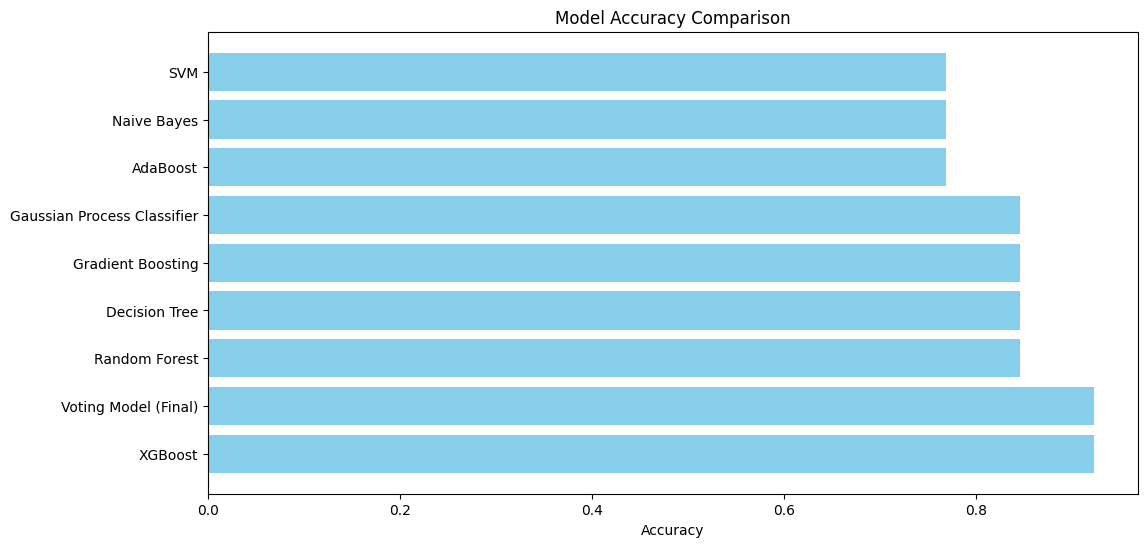

In [ ]:
import matplotlib.pyplot as plt

# ✅ Store Final Accuracies for All Models
model_accuracies = {
    "AdaBoost": 0.7692,
    "XGBoost": 0.9231,
    "Random Forest": 0.8462,
    "Decision Tree": 0.8462,
    "Naive Bayes": 0.7692,
    "Gradient Boosting": 0.8462,
    "Gaussian Process Classifier": 0.8462,
    "SVM": 0.7692,
    "Voting Model (Final)": 0.9231
}

# ✅ Sort Models by Accuracy
models, accuracies = zip(*sorted(model_accuracies.items(), key=lambda x: x[1], reverse=True))

# ✅ Plot Model Accuracy Comparison
plt.figure(figsize=(12, 6))
plt.barh(models, accuracies, color='skyblue')
plt.xlabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.show()


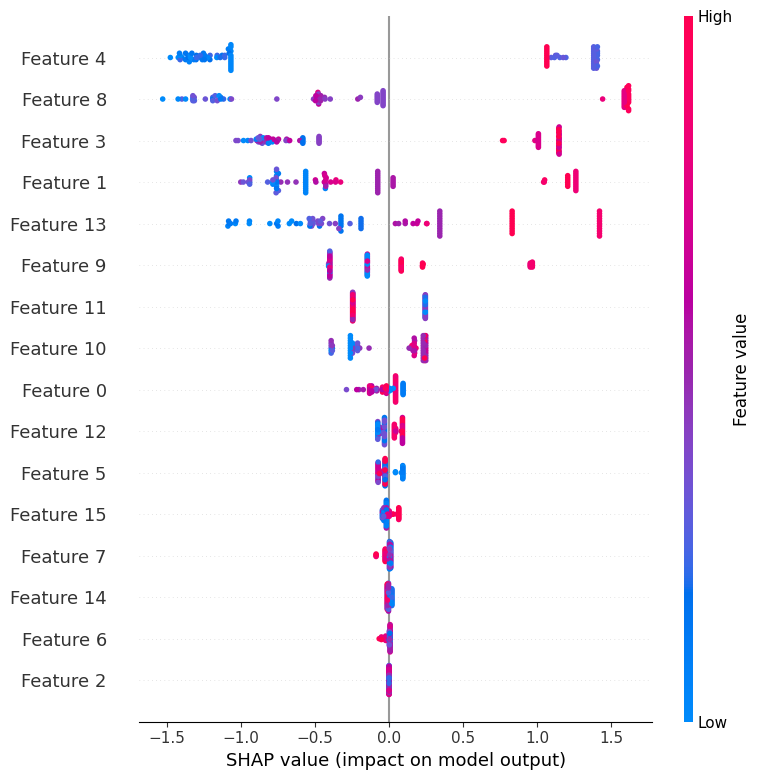

In [ ]:
import shap

# ✅ Extract the XGBoost model from the Voting Classifier
xgb_model = voting_hybrid.estimators_[0]  # Extracts ('XGB', XGBClassifier())

# ✅ Initialize SHAP Explainer
explainer = shap.Explainer(xgb_model)

# ✅ Compute SHAP Values
shap_values = explainer(X_train_balanced)

# ✅ Visualize Feature Importance
shap.summary_plot(shap_values, X_train_balanced)


Feature 4, Feature 8, Feature 3, and Feature 1 have the most impact on model output.

Feature 6 and Feature 2 have very low impact, meaning they might not be useful for classification.

Feature 12, Feature 5, Feature 15, Feature 7, Feature 14, Feature 6, Feature 2 are also on the lower impact side, so we can consider removing them and retraining the models.

In [ ]:
print(f"X_train_balanced shape: {X_train_balanced.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")


X_train_balanced shape: (86, 16)
X_test_scaled shape: (13, 20)


In [ ]:
# Ensure both datasets have the same features
common_features = min(X_train_balanced.shape[1], X_test_scaled.shape[1])

X_train_df = pd.DataFrame(X_train_balanced[:, :common_features],
                          columns=[f"Feature {i}" for i in range(common_features)])
X_test_df = pd.DataFrame(X_test_scaled[:, :common_features],
                         columns=[f"Feature {i}" for i in range(common_features)])

print(f"Updated X_train_df shape: {X_train_df.shape}")
print(f"Updated X_test_df shape: {X_test_df.shape}")


Updated X_train_df shape: (86, 16)
Updated X_test_df shape: (13, 16)


In [ ]:
# Step 1: List of least important features (Replace with actual feature names)
least_important_features = ["Feature 6", "Feature 2"]  # Example, use real SHAP results

# Step 2: Remove these features from both train & test sets
X_train_selected = X_train_df.drop(columns=least_important_features)
X_test_selected = X_test_df.drop(columns=least_important_features)

# Step 3: Verify shape consistency
print(f"Updated X_train_selected shape: {X_train_selected.shape}")
print(f"Updated X_test_selected shape: {X_test_selected.shape}")


Updated X_train_selected shape: (86, 14)
Updated X_test_selected shape: (13, 14)


In [ ]:
# ✅ Define Models Properly
models = {
    "AdaBoost": AdaBoostClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Naive Bayes": GaussianNB(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Gaussian Process Classifier": GaussianProcessClassifier(),
    "SVM": SVC(probability=True)
}

# ✅ Now, train models safely
results = {}
for name, model in models.items():
    model.fit(X_train_selected, y_train_balanced)
    y_pred = model.predict(X_test_selected)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy

# ✅ Print final accuracies
print("🔥 Final Model Accuracies After Feature Selection:")
for model, acc in results.items():
    print(f"{model}: {acc:.4f}")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:19:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


🔥 Final Model Accuracies After Feature Selection:
AdaBoost: 0.8462
XGBoost: 0.9231
Random Forest: 0.9231
Decision Tree: 0.9231
Naive Bayes: 0.9231
Gradient Boosting: 0.9231
Gaussian Process Classifier: 0.9231
SVM: 0.9231


In [ ]:
import joblib

# Use the correct model name (check your training step)
joblib.dump(xgb_model, "best_model.pkl")  # Change to actual variable name

print("✅ Best model saved as 'best_model.pkl'")


✅ Best model saved as 'best_model.pkl'


In [ ]:
joblib.dump(voting_hybrid, "best_model.pkl")  # Replace with the correct hybrid model variable

print("✅ Hybrid model saved as 'best_model.pkl'")


✅ Hybrid model saved as 'best_model.pkl'


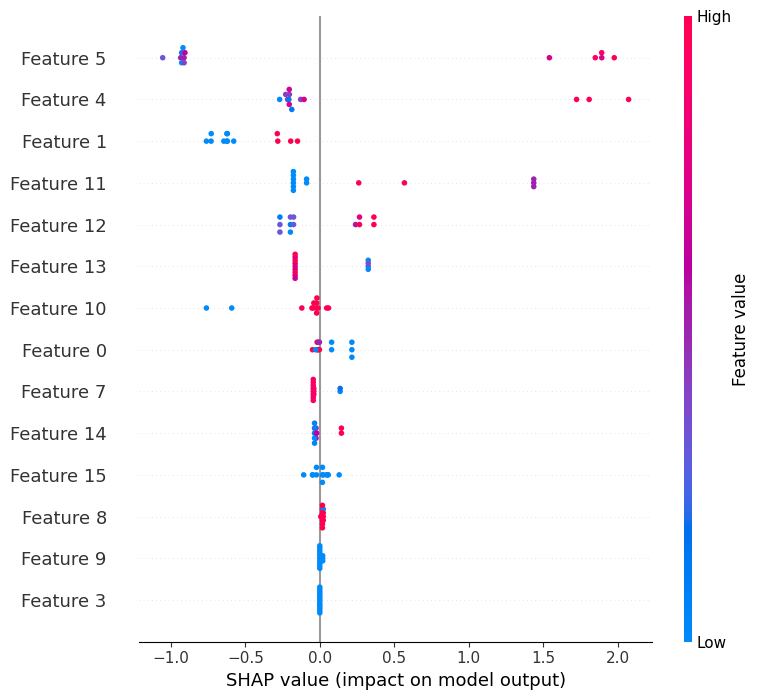

In [ ]:
import shap

# ✅ Create SHAP Explainer
explainer = shap.Explainer(xgb_model, X_train_selected)

# ✅ Compute SHAP Values with Additivity Check Disabled
shap_values = explainer(X_test_selected, check_additivity=False)

# ✅ Summary Plot (Shows Global Feature Importance)
shap.summary_plot(shap_values, X_test_selected, feature_names=X_train_selected.columns)
